In [1]:
#import the neccesary libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
import skimage
import skimage.transform
import os
import tensorflow.keras.backend as K
from skimage.metrics import structural_similarity as ssim
import math
from tensorflow.keras.applications.vgg16 import VGG16
from sobel_edge import sobel 

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import skimage.transform

def CreateSet(input_list,input_dir,output_dir,N_patches,patchsize,H,W):
    """
    Creates an array that can be used as input and output for the model
    parameters: input_list, a list with indices of the images that are used
                N_patches, the amount of image patches the model creates per image
                patchsize, the width and height of the square image patch
    
    """
    X = np.zeros((len(input_list)*N_patches, patchsize, patchsize, 1), dtype=np.float32)
    y = np.zeros((len(input_list)*N_patches, patchsize, patchsize, 1), dtype=np.float32)
    for j in range(N_patches):
        for n,i in enumerate(input_list):
            #random pixel location
            ii = j*len(input_list)+n
            xloc = random.randint(0,W-patchsize)
            yloc = random.randint(0,H-patchsize)
            #input 
            img_input = Image.open(input_dir+'/input_%03d.png' % (i+1))
            in_img_input = tf.keras.preprocessing.image.img_to_array(img_input)
            in_img_input = in_img_input[yloc:yloc+patchsize,xloc:xloc+patchsize]
            in_img_input = skimage.transform.resize(in_img_input , (patchsize , patchsize , 1) , mode = 'constant' , preserve_range = True)
            X[ii] = in_img_input / 255.0

            #output
            img_output = Image.open(output_dir+'/target_%03d.png' % (i+1))
            in_img_output = tf.keras.preprocessing.image.img_to_array(img_output)
            in_img_output = in_img_output[yloc:yloc+patchsize,xloc:xloc+patchsize]
            in_img_output = skimage.transform.resize(in_img_output , (patchsize , patchsize , 1) , mode = 'constant' , preserve_range = True)
            in_img_output = in_img_output-in_img_input
            y[ii] = in_img_output / 255.0
            if ii % 1000 == 0:
                print(ii)
    print('Done')
    return X,y
#This function can be used for small datasets 
#amount of patches per image
N_patches = 64
#width and height of the patches
patchsize = 128
#image dimensions
H=801
W=401
input_dir = 'bandLimited'
output_dir = 'groundTruth'
# input_dir = 'CIRSBandLimited'
# output_dir = 'CIRSGroundTruth'
# input_dir = 'carotidBandLimited'
# output_dir = 'carotidGroundTruth'

#Train set is image 1 till 401
X_train,y_train = CreateSet(range(401),input_dir,output_dir,N_patches,patchsize,H,W)
#validation set is image 402 till 535
X_valid,y_valid = CreateSet(range(401,535),input_dir,output_dir,N_patches,patchsize,H,W)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
Done
0
1000
2000
3000
4000
5000
6000
7000
8000
Done


In [75]:
def CustomImgGenPNG(path_train_input_list,path_train_output_list,indlst_train,H,W,
                   patchsize,N_patches,onlyX=False,shuffle=False,BATCH_SIZE=16):
    """
    Function that creates an image generator
    parameters:
                path_train_input_list: a list of paths of the npy files of the train input
                path_train_output_list: a list of paths of the npy files of the train output
                indlst_train: A list of indices that are used in the npy arrray
                H: The height of the image
                W: The width of the image
                OnlyX: When True uses only the input batch not the output batch
                shuffle:When True shuffles the list with indices
                Batch_size: the amount of images used per batch
    Yield: (Xbatch, Ybatch) When OnlyX = False
           (Xbatch) when OnlyX = True
    """
    # image number, file number, patch number
    index = []
    
    for filenr in range(len(path_train_input_list)):
        for imagenr in indlst_train[filenr]:
            for patchnr in range(N_patches):
                index.append((filenr,imagenr,patchnr))
    while True:
        if(shuffle):
            random.shuffle(index)
        L_train = len(index)
        left = L_train
        ii = 0
        while left>0:
            BL = min(BATCH_SIZE,left)
            #Create two empty arrays for BL amount of images
            X_BATCH = np.zeros((BL,patchsize,patchsize,1))
            Y_BATCH = np.zeros((BL,patchsize,patchsize,1))
            #loop over all images in the batch
            for bi in range(BL):
                #Generate a random point in the image
                yloc = random.randint(0,H-patchsize)
                xloc = random.randint(0,W-patchsize)
                input_dir = path_train_input_list[index[ii][0]]
                if(not onlyX):
                    #load the output file
                    output_dir = path_train_output_list[index[ii][0]]
                #input images
                img_input = Image.open(input_dir+'/input_%03d.png' % (index[ii][1]+1))
                in_img_input = tf.keras.preprocessing.image.img_to_array(img_input)
                in_img_input = in_img_input[yloc:yloc+patchsize,xloc:xloc+patchsize]
#                 in_img_input = skimage.transform.resize(in_img_input , (patchsize , patchsize , 1) , mode = 'constant' , preserve_range = True)
                X_BATCH[bi,:,:,:] = in_img_input / 255.0
                if(not onlyX):
                    #output
                    img_output = Image.open(output_dir+'/target_%03d.png' % (index[ii][1]+1))
                    in_img_output = tf.keras.preprocessing.image.img_to_array(img_output)
                    in_img_output = in_img_output[yloc:yloc+patchsize,xloc:xloc+patchsize]
#                     in_img_output = skimage.transform.resize(in_img_output , (patchsize , patchsize , 1) , mode = 'constant' , preserve_range = True)
                    in_img_output = in_img_output-in_img_input
                    Y_BATCH[bi,:,:,:] = in_img_output / 255.0
                ii+=1
            left = left - BL
            if(not onlyX):
                yield (X_BATCH,Y_BATCH)
            else:
                yield X_BATCH

#The image generator can be used if there is a lack of memory, it is however a lot slower
#amount of patches per image
N_patches = 64
#width and height of the patches
patch_size = 128
batch_size = 16
H=801
W=401
# input_dir = 'bandLimited'
# output_dir = 'groundTruth'
# input_dir = 'CIRSBandLimited'
# output_dir = 'CIRSGroundTruth'
#Give a list with input and output directories
input_dir = ['bandLimited']
output_dir = ['groundTruth']
#Give a list with lists that contain the indices for the respective directories
indlist_train = [range(401)]
indlist_val = [range(401,535)]

#The amount of images that are generated each epoch
N_TRAIN = 0 
N_VALIDATE = 0
for i in range(len(input_dir)):
    N_TRAIN+=N_patches*len(indlist_train[i])
    N_VALIDATE+=N_patches*len(indlist_val[i])

#amount of steps of the training and validation set each epoch
t_steps = math.ceil(N_TRAIN/batch_size)
v_steps = math.ceil(N_VALIDATE/batch_size)

#Define the generator for both the train set and validation set
# ImgGenTrain = CustomImgGenPNG(input_dir,output_dir,indlist_train,H=H,W=W,patchsize=patch_size,N_patches=N_patches,BATCH_SIZE=batch_size)
# ImgGenVal = CustomImgGenPNG(input_dir,output_dir,indlist_val,H=H,W=W,patchsize=patch_size,N_patches=N_patches,BATCH_SIZE=batch_size)

In [2]:
def SRCNN():
    # lrelu = LeakyReLU(alpha=0.1)
    SRCNN = tf.keras.Sequential()
    SRCNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size= (9,9),  kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', input_shape=(None, None, 1)))
    SRCNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size= (3,3),  kernel_initializer='glorot_uniform',
                     activation='relu', padding='same'))
    # SRCNN.add(BatchNormalization())
    SRCNN.add(tf.keras.layers.Conv2D(filters=1, kernel_size= (5,5),  kernel_initializer='glorot_uniform',
                     activation='linear', padding='same'))
    adam = tf.keras.optimizers.Adam(lr=0.0003)
    SRCNN.compile(optimizer=adam, loss=CustomMSE, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return SRCNN


In [3]:
def CustomMSE(y_predict,y_true):
    factor = 1e3
    mse = factor*K.mean(K.square(y_predict-y_true))
    return mse
    

In [4]:
#define and compile the model
# img_tensor = tf.keras.layers.Input((None , None , 1) , name = 'img_tensor')
model = SRCNN()

In [5]:
model_path = 'model_SRCNN_residual_ultrasound.h5'
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_best_only=True, save_weights_only=True)
]

In [6]:
#load the model
model.load_weights(model_path)

In [ ]:
model.summary()

In [9]:
#train the model
results = model.fit(X_train,y_train, epochs=100, callbacks=callbacks,batch_size = 16,
                    validation_data=(X_valid,y_valid),shuffle=False)


Epoch 1/100
1604/1604 [==============================] - ETA: 0s - loss: 8.8744 - root_mean_squared_error: 0.0942
Epoch 00001: val_loss improved from inf to 9.19631, saving model to model_SRCNN_residual_ultrasound.h5
1604/1604 [==============================] - 34s 21ms/step - loss: 8.8744 - root_mean_squared_error: 0.0942 - val_loss: 9.1963 - val_root_mean_squared_error: 0.0959 - lr: 3.0000e-04
Epoch 2/100
1602/1604 [============================>.] - ETA: 0s - loss: 8.8676 - root_mean_squared_error: 0.0942
Epoch 00002: val_loss did not improve from 9.19631
1604/1604 [==============================] - 35s 22ms/step - loss: 8.8677 - root_mean_squared_error: 0.0942 - val_loss: 9.2838 - val_root_mean_squared_error: 0.0964 - lr: 3.0000e-04
Epoch 3/100
1602/1604 [============================>.] - ETA: 0s - loss: 8.8584 - root_mean_squared_error: 0.0941
Epoch 00003: val_loss did not improve from 9.19631
1604/1604 [==============================] - 34s 21ms/step - loss: 8.8586 - root_mean_squ

Epoch 23/100
1603/1604 [============================>.] - ETA: 0s - loss: 8.7912 - root_mean_squared_error: 0.0938
Epoch 00023: val_loss did not improve from 8.95926
1604/1604 [==============================] - 34s 21ms/step - loss: 8.7918 - root_mean_squared_error: 0.0938 - val_loss: 8.9612 - val_root_mean_squared_error: 0.0947 - lr: 1.0000e-04
Epoch 24/100
1602/1604 [============================>.] - ETA: 0s - loss: 8.7899 - root_mean_squared_error: 0.0938
Epoch 00024: val_loss did not improve from 8.95926
1604/1604 [==============================] - 34s 21ms/step - loss: 8.7902 - root_mean_squared_error: 0.0938 - val_loss: 8.9657 - val_root_mean_squared_error: 0.0947 - lr: 1.0000e-04
Epoch 25/100
1603/1604 [============================>.] - ETA: 0s - loss: 8.7884 - root_mean_squared_error: 0.0937
Epoch 00025: val_loss did not improve from 8.95926
1604/1604 [==============================] - 34s 21ms/step - loss: 8.7889 - root_mean_squared_error: 0.0937 - val_loss: 8.9646 - val_root_

Epoch 46/100
1603/1604 [============================>.] - ETA: 0s - loss: 8.7632 - root_mean_squared_error: 0.0936
Epoch 00046: val_loss improved from 8.94042 to 8.93698, saving model to model_SRCNN_residual_ultrasound.h5
1604/1604 [==============================] - 35s 22ms/step - loss: 8.7638 - root_mean_squared_error: 0.0936 - val_loss: 8.9370 - val_root_mean_squared_error: 0.0945 - lr: 1.0000e-04
Epoch 47/100
1604/1604 [==============================] - ETA: 0s - loss: 8.7628 - root_mean_squared_error: 0.0936
Epoch 00047: val_loss did not improve from 8.93698
1604/1604 [==============================] - 35s 22ms/step - loss: 8.7628 - root_mean_squared_error: 0.0936 - val_loss: 8.9405 - val_root_mean_squared_error: 0.0946 - lr: 1.0000e-04
Epoch 48/100
1603/1604 [============================>.] - ETA: 0s - loss: 8.7602 - root_mean_squared_error: 0.0936
Epoch 00048: val_loss did not improve from 8.93698
1604/1604 [==============================] - 35s 22ms/step - loss: 8.7608 - root_m

KeyboardInterrupt: 

In [ ]:
#visualise the accuracy and losses of the model
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['root_mean_squared_error'])
plt.plot(results.history['val_root_mean_squared_error'])
plt.title('model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
#Make an array with all the images in the train and validation set
Train_set_indices = range(535)
Train_set_X = np.zeros((len(Train_set_indices), 801, 401,1), dtype=np.float32)
for i in Train_set_indices:
    img = Image.open('bandLimited/input_%03d.png' % (i+1))
    in_img_input = tf.keras.preprocessing.image.img_to_array(img)
    in_img_input = skimage.transform.resize(in_img_input , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
    Train_set_X[i] =in_img_input / 255.0

In [9]:
#Generate the model output for the images in the train and validation set 
prediction_images = np.zeros((len(Train_set_X),801,401),dtype=np.float32)
for i in Train_set_indices:
    prediction_image = model.predict(np.expand_dims(Train_set_X[i] , 0))
    prediction_image = prediction_image.squeeze()+Train_set_X[i].squeeze()
    prediction_image = prediction_image*255.0
    prediction_image  = Image.fromarray(prediction_image)
    if prediction_image.mode == "F":
        prediction_image = prediction_image.convert('RGB')
    prediction_image.save('bandlimited_SRCNNmodel2/input_%03d.png' % (i+1))
    

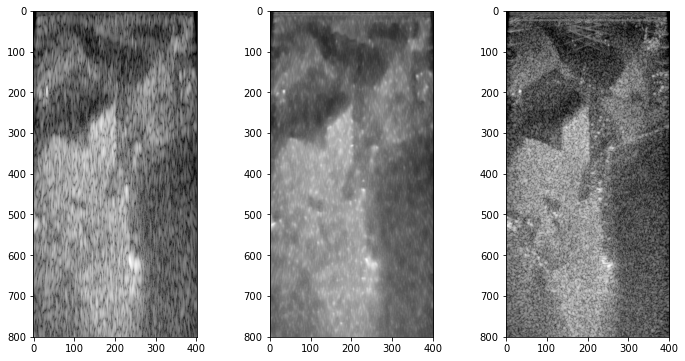

In [10]:
#Show the nth image in the test set
n =6

#make the model predicted image
prediction = model.predict(np.expand_dims(Test_set_X[n] , 0))
prediction_image = prediction.squeeze()

fig,ax = plt.subplots(1,3, figsize=(12,6))
#bandwidth limited image
ax[0].imshow(Test_set_X[n].squeeze(),cmap = 'gray')
#Model generated image
ax[1].imshow(Test_set_X[n].squeeze()+prediction_image,cmap='gray')
#original image
ax[2].imshow(Test_set_y[n].squeeze(),cmap='gray')
plt.show()

In [12]:
#Create the arrays for the Test set which are the image 535 till 669
def CreateTestSet(test_set_indices,input_dir_test,output_dir_test):
    Test_set_X = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
    Test_set_y = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
    for i,n in enumerate(test_set_indices):
        img = Image.open(input_dir_test+'/input_%03d.png' % (n+1))
        in_img_input = tf.keras.preprocessing.image.img_to_array(img)
        in_img_input = skimage.transform.resize(in_img_input , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
        Test_set_X[i] =in_img_input / 255.0

        img = Image.open(output_dir_test+'/target_%03d.png' % (n+1))
        in_img_output = tf.keras.preprocessing.image.img_to_array(img)
        in_img_output = skimage.transform.resize(in_img_output , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
        Test_set_y[i] =in_img_output / 255.0    
    print('Done')
    return Test_set_X, Test_set_y
for dataset in ['','CIRS_','carotid_']:
    if dataset == '':
        test_set_indices = range(535,669)
        input_dir_test = 'bandLimited'
        output_dir_test = 'groundTruth'
    if dataset == 'CIRS_':
        test_set_indices = range(11)
        input_dir_test = 'CIRSBandLimited'
        output_dir_test = 'CIRSGroundTruth'
    if dataset =='carotid_':
        test_set_indices = range(70)
        input_dir_test = 'carotidBandLimited'
        output_dir_test = 'carotidGroundTruth'
    Test_set_X, Test_set_y = CreateTestSet(test_set_indices,input_dir_test,output_dir_test)
    prediction_images = np.zeros((len(Test_set_X),801,401),dtype=np.float32)
    for i in range(len(Test_set_X)):
        prediction_image = model.predict(np.expand_dims(Test_set_X[i] , 0))
        prediction_images[i] = prediction_image.squeeze()+Test_set_X[i].squeeze()
    np.save('Model_output_test_'+dataset+'SRCNNmodel2_ultrasound.npy',prediction_images)
    

Done
Done
Done
